In [1]:
import csv
import nltk
import pandas as pd  
import numpy as np
import nltk
from collections import Counter
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
import contractions
import string
from nltk.corpus import wordnet
import datetime
import enchant
import re
import json
import os
import html
import calendar
from nltk.tokenize import treebank
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import opinion_lexicon
from nltk.parse.corenlp import CoreNLPParser
from nltk.tag import StanfordNERTagger as snt
#from pycorenlp import StanfordCoreNLP
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# check to see basic encoding 
import chardet
with open('/Users/RonMBP2/NLP_Joltes/HSCX/NLP_Project/Data/CustomerReviewPlainText.txt', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result



In [ ]:
# Convert raw data into a Pandas DataFrame; change some fields to DateTime data types
df = pd.read_csv('/Users/RonMBP2/NLP_Joltes/HSCX/NLP_Project/Data/CustomerReviewPlainText.txt',encoding='ISO-8859-1')
df['month_year'] = pd.to_datetime(df['Service Date']).dt.to_period('M')
df['month'] = pd.to_datetime(df['Service Date']).dt.month
df['year'] = pd.to_datetime(df['Service Date']).dt.year
df.head(4)

In [ ]:
# Check general format of data 
df.info()

In [ ]:
# Check for null values in the "Service Comment" feature and drop if == null
ls=[]
for i in range(len(df["Service Comment"])):
    if pd.isnull(df.loc[i,"Service Comment"]) == True:
        ls.append(i)
    else:
        length=len(df.loc[i,"Service Comment"])
        for j in range(length):
            if df.loc[i,"Service Comment"][j].isalpha()== True:
                break
            else:
                length -=1

        if length==0:
            ls.append(i)
print(ls)

In [ ]:
df.drop([592, 2399, 2400, 2528, 2635, 3466, 4083, 4445, 4480, 4505, 4628, 4833, 5390, 6374, 7061, 7136, 7565, 7578, 7879, 7968, 7969, 8075, 8248, 8267, 8696, 8794, 8947, 9525, 9671, 9834, 9934],0,inplace=True)

In [ ]:
# Re-index remaining rows
df.index = range(10188)

In [ ]:
### FIXME: MOVE FUNCTION TO TOP OF CODE

# Function to append POS to text tokens
def get_wordnet_pos(tag):
        if tag.startswith('J'):
                return wordnet.ADJ
        elif tag.startswith('V'):
                return wordnet.VERB
        elif tag.startswith('N'):
                return wordnet.NOUN
        elif tag.startswith('R'):
                return wordnet.ADV
        else:
                return None

# Declare list "res" to store cleaned, tokenized & lemmatized "Service Comment" text
res=[]

# Intantiate Lemmatizer
lemmatizer=WordNetLemmatizer()

# Clean & Tokenize text from "Service Comment" feature
# (nb: time to run is substantial)
for i in df["Service Comment"]:
    num_remove=''.join([x for x in i if not x.isdigit()])
    low_case = num_remove.lower()
    contract = contractions.fix(low_case)
    punctuation = ''.join([y for y in contract if y not in string.punctuation])
    tokens=word_tokenize(punctuation)
    tags=nltk.pos_tag(tokens)
    sentence=[]
    for tag in tags:
        wordnet_pos = get_wordnet_pos(tag[1])
        if wordnet_pos is None:
            lemma=tag[0]
        else:
            lemma=lemmatizer.lemmatize(tag[0], pos=wordnet_pos)
        sentence.append(lemma)
    row =' '.join([w for w in sentence if w not in stopwords.words()])
    res.append(row)

df.loc[:,'Review_revised'] = res


In [ ]:
# create an external copy of the previous action 
df.to_csv('reviews_revised.csv', index=False)

In [ ]:
import enchant
not_eng=[]
d = enchant.Dict("en_US")
for i in range(len(df["Review_revised"])):
    tokens=word_tokenize(df.loc[i,"Review_revised"])
    for word in tokens:
        if d.check(word)==False:
            not_eng.append((word))
        else:
            continue
print(not_eng)

In [ ]:
cnt=Counter(not_eng)
print(cnt.most_common(10))

In [ ]:
spanish=[]
for i in range(len(df["Review_revised"])):
    tokens=word_tokenize(df.loc[i,"Review_revised"])
    for word in tokens:
        if word=="servicio":
            spanish.append(i)
print(spanish) 

In [ ]:
df.drop([242, 577, 980, 1366, 1758, 2100, 2175, 2497, 2932, 3001, 3394, 4278, 5330, 6292, 6732, 6893, 7417, 9017],0,inplace=True)

In [ ]:
df.info()

In [ ]:
df.index=range(10170)

In [ ]:
# correct spelling for common misspellings
comment=[]
for i in df["Service Comment"]:
    tokens=word_tokenize(i)
    text=[]
    for word in tokens:
        if word.lower()=="knowledgable":
            word = "knowledgeable"
        if word.lower()=="didnt":
            word="didn't"
        if word.lower()=="dont":
            word="don't"
        if word.lower()=="user-friendly":
            word="user friendly"
        if word.lower()=="signup":
            word="sign up"
        text.append(word)
    row =' '.join(text)
    comment.append(row)
df.loc[:,'Review_correct'] = comment

In [ ]:
# Tokenize the Review_revised feature
length=[]
for i in range(0,len(df["Review_revised"])):
    if len(word_tokenize(df.loc[i,"Review_revised"]))<3:
        length.append(i)

In [ ]:
df_test=df.copy()
rows = df_test.index[length]
df_test.drop(rows, inplace=True)

In [ ]:
df.info()
df_test.info()

In [ ]:
df_rd = df_test[['month_year','month','year','Service Comment','Review_correct','Service Star Feedback']]
df_rd.rename(columns={'Service Star Feedback': 'ratings'}, inplace=True)
df_rd.head(3)

In [ ]:
suspicious_chars = re.compile(r'[&#<>{}\[\]\\]')


##FIXME: PUT FUNCTION AT HEAD

def impurity(text, min_len=10):
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(suspicious_chars.findall(text))/len(text)
    
df_rd['impurity'] = df_rd['Review_correct'].apply(impurity, min_len=10).round(2)
df_rd[['Review_correct', 'impurity']].sort_values(by='impurity', ascending=False).head(10)

In [ ]:
## FIXME: PUT FUNCTION AT HEAD

# Additional data cleaning
def clean_data(text):
    text = html.unescape(text)
    text = re.sub(r'<[^<>]*>', ' ', text)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('[!@#$%]', ' ', text)
    return text.strip()

df_rd['clean_reviews']  = df_rd['Review_correct'].apply(clean_data)
df_rd[['clean_reviews','Review_correct', 'impurity']].sort_values(by='impurity', ascending=False).head(10)

In [ ]:
# Create a feature called "token_length" to determine how many tokens in each review; sorted by length
df_rd['token_length'] = [len(x.split(" ")) for x in df_rd.clean_reviews]
df_rd.sort_values('token_length')

In [ ]:
# Plot histogram of token_length to visualize distribution
plt.figure(figsize=(12,6))
sns.set(style="ticks", color_codes=True)
df_rd['token_length'].hist(bins=50)
plt.title("Histogram of Token Length", fontsize = 20)
plt.xlabel("Token Length", fontsize=15)
plt.ylabel("Count",fontsize=15)

In [ ]:
# Plot histogram of Service Star Feedback count to visualize distribution
rating_count = df_rd['ratings'].value_counts(normalize = True).round(2) * 100 
plt.figure(figsize=(12,6))
sns.set(style="whitegrid", color_codes=True)
sns.barplot(rating_count.index, 
            rating_count.values, 
            alpha = 1,
            order = rating_count.index,
            palette="rocket")
plt.title("Count of Service Star Feedback", fontsize = 20)
plt.ylabel('% of Occurrences', fontsize = 15)
plt.xlabel('Ratings', fontsize = 15)
plt.xticks()
plt.show()

In [ ]:
annual_review_cnt = df_rd.groupby('year').count()['ratings'].reset_index()
plt.figure(figsize=(12,6))
plt.title("Count of Reviews by Year", fontsize = 20)
sns.set(style="darkgrid", color_codes=True)
ax = sns.barplot(x="year", y= "ratings", data = annual_review_cnt)

In [ ]:
# Plot comparing count of ratings by month & year
df_rd['month_char'] = df_rd['month'].apply(lambda x: calendar.month_abbr[x])
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_pivoted = pd.pivot_table(df_rd,index=["month_char"],
               values=["ratings"],
               aggfunc='count',fill_value=0,
               columns=["year"]
                      ).reindex(ordered_months)

df_pivoted.plot(kind='bar', figsize=(18, 10), 
                rot=0)                                       
plt.title("Historical Count of Service Ratings: Month by Month Comparison", y=1.015, fontsize=18)
plt.xlabel("Months", labelpad=20)
plt.ylabel("Count of Ratings", labelpad=20)

In [ ]:
# wt_avg = ((5-star monthly counts)*5+(4-star monthly counts)*4+…..+(1-star monthly counts)*1)/sum of monthly count
#yr = df[df['year'] == 2020]
monthly_cnt =df_rd.groupby(['month_year','year','month','month_char','ratings']).size()
cdf  = monthly_cnt.to_frame(name='count').reset_index()

## FIXME: MOVE FUNCTION
def wt_avg(agg):
    weights = agg['count']
    ratings = agg['ratings']   
    return np.average(ratings,weights=weights)

wt = cdf.groupby(['month_year','year','month_char']).apply(func = wt_avg)
ndf = wt.to_frame(name='Star_Rating_wt_avg').reset_index()

plt.figure(figsize=(18, 10))
sns.barplot(x='month_char', y='Star_Rating_wt_avg', hue='year',
                      data=ndf.query('year>2016'), order=ordered_months)
plt.title("Weighted Avg of Service Ratings: Month by Month Comparison", y=1.015, fontsize=18)
plt.ylabel('Weighted Avg.', fontsize = 12)
plt.xlabel("Months", fontsize=12)
plt.xticks()

In [ ]:
# What is the service rating trend over time?
# We use a weighted average for smoothing
ndf.plot(kind='line',x='month_year',y='Star_Rating_wt_avg', figsize=(18, 10), rot=0)                                       
plt.title("Service Rating Trend", y=1.015, fontsize=18)
plt.xlabel("Year-Month", labelpad=20)
plt.ylabel("Weighted Avg.", labelpad=20)

In [ ]:
## NLP ANALYSIS OF REVIEW SENTIMENT ##

# Scoring with StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9000')
def SentimentScore(text):
    results = nlp.annotate(text, properties={
        "annotators": "sentiment",
        "outputFormat": "json",
        'timeout': 1000000,
    })

    score = []
    for i in range(0,len(results['sentences'])):
        score.append((int(json.loads(results['sentences'][i]['sentimentValue']))+1))

    #average the result by dividing total_sentiment / num_sentences
    sentiment_results = sum(score)/len(score)
    count = len(score)

    return(round(sentiment_results))

df_rd['StanCoreNLP_Score']= df_rd['clean_reviews'].apply(SentimentScore)


smpl_reviews = df_rd[['clean_reviews','ratings','StanCoreNLP_Score']].sample(10)
smpl_reviews

# Explore a sample of negative reviews
print ("A sample of negative reviews\n")
negative_reviews = df_rd[df_rd.ratings < 3]#df.sample(10)
negative_reviews[['clean_reviews','ratings','StanCoreNLP_Score']].sample(10)

# Explore a sample of positive reviews
print ("A sample of positive reviews\n")
# Explore a sample of positive reivews
positive_reviews = df_rd[df_rd.ratings > 3]#df.sample(10)
positive_reviews[['clean_reviews','ratings','StanCoreNLP_Score']].sample(10)

# Create a new feature that shows the difference between Star Ratings and NLP Core Scores
df_rd['diff_ratings_StanCoreNLP_Score'] = abs(df_rd["ratings"] - df_rd["StanCoreNLP_Score"])
print("A sample table of abolute differences between Star Ratings and NLPCore Score")
df_rd[['clean_reviews','ratings','StanCoreNLP_Score','diff_ratings_StanCoreNLP_Score']].sample(10)



# Plot distribution of Stanford CoreNLP Score
rating_count = df_rd['StanCoreNLP_Score'].value_counts(normalize = True).round(2) * 100 
plt.figure(figsize=(12,6))
sns.set(style="darkgrid", color_codes=True)
sns.barplot(rating_count.index, 
            rating_count.values, 
            alpha = 1,
            order = rating_count.index,
            palette="rocket")
plt.title("Stanford CoreNLP Sentiment Score", fontsize = 20)
plt.ylabel('% of Occurrences', fontsize = 15)
plt.xlabel('CoreNLP Sentiment Score', fontsize = 15)
plt.xticks()
plt.show()

# What is the distribution of differences?
print("\n")
print("A % distribution of differences between Star Ratings and NLPCore Scores:")
diff_pct = df_rd['diff_ratings_StanCoreNLP_Score'].value_counts(normalize = True).round(2) * 100
diff_pct


# Find the Starford CoreNlP weighted avgerage
nlp_monthly_cnt =df_rd.groupby(['month_year','year','month','month_char','StanCoreNLP_Score']).size()
cdf1  = nlp_monthly_cnt.to_frame(name='nlp_count').reset_index()
#cdf.head(2)
def wt_average(agg):
    weights = agg['nlp_count']
    StanCoreNLP_Score = agg['StanCoreNLP_Score']   
    return np.average(StanCoreNLP_Score,weights=weights)


# Plot both weighted averages for NLPCore Score and Star Ratings 
wt1 = cdf1.groupby(['month_year','year','month_char']).apply(func = wt_average)
ndf1 = wt1.to_frame(name='StanfordCoreNLP_wt_avg').reset_index()
ndf['StanfordCoreNLP_wt_avg'] = pd.Series(ndf1['StanfordCoreNLP_wt_avg'])

ndf.set_index(['year','month_char']).plot(figsize=(18, 10), grid=True)
plt.title("Weighted Avg. Trend: Stanford CoreNLP Sentiment Score vs Service Star Rating", y=1.015, fontsize=18)
plt.xlabel("Year-Month", labelpad=20)
plt.ylabel("Weighted Avg.", labelpad=20)




Positive Reviews:


Top 10 Bigrams for 2016
----------------------------------
answer question ---> 8
customer service ---> 6
fast service ---> 4
great easy ---> 4
excellent service ---> 3
fast efficient ---> 3
good service ---> 3
friendly helpful ---> 3
far good ---> 3
fair price ---> 3


Top 10 Trigrams for 2016
----------------------------------
service fast efficient ---> 2
experience great easy ---> 2
low cost compressive ---> 1
cost compressive coverage ---> 1
compressive coverage small ---> 1
coverage small start ---> 1
small start experience ---> 1
start experience awesome ---> 1
experience awesome handle ---> 1
awesome handle sense ---> 1


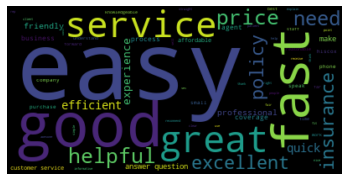

Negative Reviews:


Top 10 Bigrams for 2016
----------------------------------
charge incorrectly ---> 1
incorrectly ask ---> 1
ask get ---> 1
get charge ---> 1
charge annually ---> 1
annually charge ---> 1
charge monthly ---> 1
monthly mistake ---> 1
mistake expect ---> 1
expect faster ---> 1


Top 10 Trigrams for 2016
----------------------------------
charge incorrectly ask ---> 1
incorrectly ask get ---> 1
ask get charge ---> 1
get charge annually ---> 1
charge annually charge ---> 1
annually charge monthly ---> 1
charge monthly mistake ---> 1
monthly mistake expect ---> 1
mistake expect faster ---> 1
expect faster resolution ---> 1


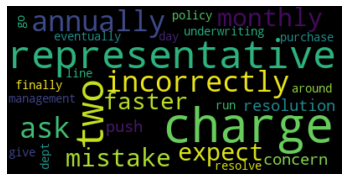

Positive Reviews:


Top 10 Bigrams for 2017
----------------------------------
customer service ---> 269
answer question ---> 95
quick easy ---> 84
easy use ---> 72
fast easy ---> 65
great customer ---> 63
small business ---> 61
would recommend ---> 56
great service ---> 52
easy process ---> 52


Top 10 Trigrams for 2017
----------------------------------
great customer service ---> 62
customer service great ---> 25
excellent customer service ---> 22
good customer service ---> 19
would definitely recommend ---> 18
yes would recommend ---> 13
customer service rep ---> 13
customer service representative ---> 13
would highly recommend ---> 12
highly recommend hiscox ---> 12


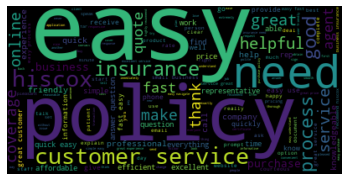

Negative Reviews:


Top 10 Bigrams for 2017
----------------------------------
call back ---> 6
customer service ---> 5
insurance company ---> 5
tell would ---> 5
still wait ---> 4
get pay ---> 3
receive policy ---> 3
never receive ---> 3
sign insurance ---> 3
credit card ---> 3


Top 10 Trigrams for 2017
----------------------------------
update payment information ---> 2
payment information online ---> 2
terrible customer service ---> 1
customer service cancel ---> 1
service cancel policy ---> 1
cancel policy agent ---> 1
policy agent give ---> 1
agent give application ---> 1
give application email ---> 1
application email send ---> 1


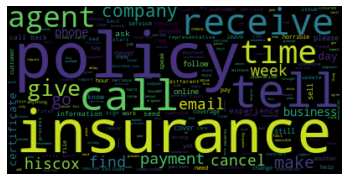

Positive Reviews:


Top 10 Bigrams for 2018
----------------------------------
customer service ---> 260
great customer ---> 84
quick easy ---> 80
answer question ---> 76
would recommend ---> 71
fast easy ---> 68
easy process ---> 67
small business ---> 65
easy use ---> 64
great service ---> 53


Top 10 Trigrams for 2018
----------------------------------
great customer service ---> 76
excellent customer service ---> 27
customer service great ---> 23
small business owner ---> 20
good customer service ---> 20
would recommend hiscox ---> 19
yes would recommend ---> 16
easy get quote ---> 15
would definitely recommend ---> 13
customer service excellent ---> 13


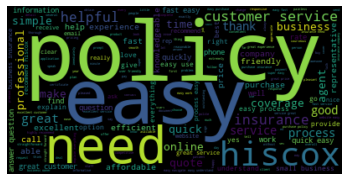

Negative Reviews:


Top 10 Bigrams for 2018
----------------------------------
customer service ---> 4
would get ---> 4
call back ---> 4
request change ---> 3
get policy ---> 3
login policy ---> 2
exist customer ---> 2
go process ---> 2
able find ---> 2
willing listen ---> 2


Top 10 Trigrams for 2018
----------------------------------
switch payment card ---> 2
find coverage approx ---> 1
coverage approx less ---> 1
approx less line ---> 1
less line could ---> 1
line could disappointed ---> 1
could disappointed hiscox ---> 1
disappointed hiscox incredibly ---> 1
hiscox incredibly poor ---> 1
incredibly poor experience ---> 1


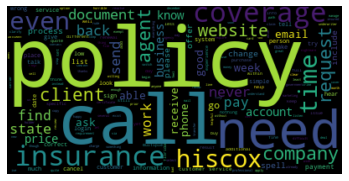

Positive Reviews:


Top 10 Bigrams for 2019
----------------------------------
customer service ---> 298
quick easy ---> 87
easy use ---> 72
great customer ---> 70
fast easy ---> 66
answer question ---> 65
great service ---> 64
easy process ---> 61
great experience ---> 55
business insurance ---> 55


Top 10 Trigrams for 2019
----------------------------------
great customer service ---> 66
excellent customer service ---> 46
customer service rep ---> 27
customer service great ---> 22
customer service easy ---> 16
would definitely recommend ---> 16
good customer service ---> 15
customer service excellent ---> 15
small business owner ---> 13
would recommend hiscox ---> 12


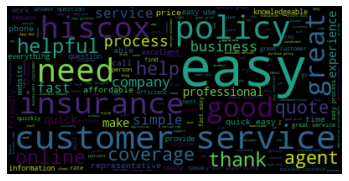

Negative Reviews:


Top 10 Bigrams for 2019
----------------------------------
call back ---> 13
customer service ---> 6
still receive ---> 5
say would ---> 4
several time ---> 4
multiple time ---> 4
certificate insurance ---> 3
cancel policy ---> 3
back get ---> 3
cancel hiscox ---> 3


Top 10 Trigrams for 2019
----------------------------------
call back get ---> 3
get certificate insurance ---> 2
call several time ---> 2
call back multiple ---> 2
back multiple time ---> 2
still receive refund ---> 2
day never get ---> 2
poor customer service ---> 2
go throw three ---> 2
purchase business insurance ---> 2


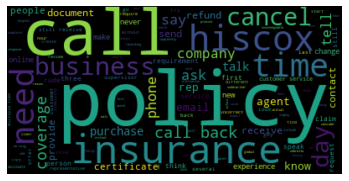

Positive Reviews:


Top 10 Bigrams for 2020
----------------------------------
customer service ---> 196
quick easy ---> 61
great customer ---> 58
answer question ---> 50
great service ---> 48
small business ---> 45
easy use ---> 44
easy get ---> 40
would recommend ---> 38
great experience ---> 37


Top 10 Trigrams for 2020
----------------------------------
great customer service ---> 55
excellent customer service ---> 20
good customer service ---> 16
customer service rep ---> 12
customer service easy ---> 11
would highly recommend ---> 11
highly recommend hiscox ---> 9
small business insurance ---> 9
easy get policy ---> 9
yes would recommend ---> 8


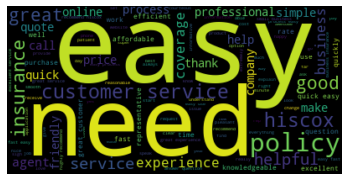

Negative Reviews:


Top 10 Bigrams for 2020
----------------------------------
customer service ---> 5
still wait ---> 3
storage unit ---> 3
week ago ---> 2
another company ---> 2
business address ---> 2
insurance policy ---> 2
question ask ---> 2
change policy ---> 2
rewrite entire ---> 2


Top 10 Trigrams for 2020
----------------------------------
rewrite entire policy ---> 2
storage unit tell ---> 2
customer service rep ---> 2
still wait document ---> 1
wait document send ---> 1
document send requirement ---> 1
send requirement week ---> 1
requirement week ago ---> 1
week ago still ---> 1
ago still nothing ---> 1


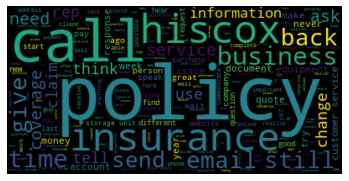

In [2]:
### N-GRAM ANALYSIS ###
data = pd.read_csv('/Users/RonMBP2/NLP_Joltes/HSCX/NLP_Project/Data/Customer_Reviews_Cleaned.csv',encoding='ISO-8859-1')
data['year'] = data['Service Date']
data['year'] = pd.to_datetime(data['year'])
data['Service Comment'] = data['Service Comment'].astype(str)
processed_data = data.copy()

# Remove rows where there are no reviews
empties = []
for i in range(len(processed_data["Review_revised"])):
    if pd.isnull(processed_data.loc[i,"Review_revised"]) == True:
        empties.append(i)
    else:
        length=len(processed_data.loc[i,"Review_revised"])
        for j in range(length):
            if processed_data.loc[i,"Review_revised"][j].isalpha()== True:
                break
            else:
                length -=1

        if length==0:
            empties.append(i)
processed_data.drop(empties)
processed_data.reset_index(drop=True)

# Create customer review dataframes for year of data
processed_data['Review_revised']=processed_data['Review_revised'].apply(str)  # ensure entire feature is string object
processed_data_2016 = processed_data[processed_data['year'].dt.year == 2016]
processed_data_2017 = processed_data[processed_data['year'].dt.year == 2017]
processed_data_2018 = processed_data[processed_data['year'].dt.year == 2018]
processed_data_2019 = processed_data[processed_data['year'].dt.year == 2019]
processed_data_2020 = processed_data[processed_data['year'].dt.year == 2020]

def getBigramsAndTrigramsForYear(year, data_year):
    data_year_str = ' '.join(data_year['Review_revised'])

    data_year_formatted_str = re.sub(r"[,@\'?\.$%_]","", data_year_str).replace("\n", " ").lower()
    nltk_tokens = nltk.word_tokenize(data_year_formatted_str)
    nltk_bigrams = list(nltk.bigrams(nltk_tokens))
    nltk_bigrams_fdist = nltk.FreqDist(nltk_bigrams)
    top10_bigrams = nltk_bigrams_fdist.most_common(10)
    print("\n")
    print("Top 10 Bigrams for {}".format(year))
    print("----------------------------------")
    for ((w1, w2), f) in top10_bigrams:
        print(w1 + " " + w2 + " --->", f)
    nltk_trigrams = list(nltk.trigrams(nltk_tokens))
    nltk_trigrams_fdist = nltk.FreqDist(nltk_trigrams)
    top10_trigrams = nltk_trigrams_fdist.most_common(10)
    print("\n")
    print("Top 10 Trigrams for {}".format(year))
    print("----------------------------------")
    for ((w1, w2, w3), f) in top10_trigrams:
        print(w1 + " " + w2 + " " + w3 + " --->", f)
    wordcloud = WordCloud().generate(data_year_formatted_str)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
# Collate positive and negative reviews by year
processed_data_2016_positive = processed_data_2016[processed_data_2016["Service Star Feedback"] >= 3]
processed_data_2016_negative = processed_data_2016[processed_data_2016["Service Star Feedback"] < 3]
processed_data_2017_positive = processed_data_2017[processed_data_2017["Service Star Feedback"] >= 3]
processed_data_2017_negative = processed_data_2017[processed_data_2017["Service Star Feedback"] < 3]
processed_data_2018_positive = processed_data_2018[processed_data_2018["Service Star Feedback"] >= 3]
processed_data_2018_negative = processed_data_2018[processed_data_2018["Service Star Feedback"] < 3]
processed_data_2019_positive = processed_data_2019[processed_data_2019["Service Star Feedback"] >= 3]
processed_data_2019_negative = processed_data_2019[processed_data_2019["Service Star Feedback"] < 3]
processed_data_2020_positive = processed_data_2020[processed_data_2020["Service Star Feedback"] >= 3]
processed_data_2020_negative = processed_data_2020[processed_data_2020["Service Star Feedback"] < 3]

# Calls to the getBigramsAndTrigramsForYear function
print("Positive Reviews:")
getBigramsAndTrigramsForYear(2016, processed_data_2016_positive)
print("Negative Reviews:")
getBigramsAndTrigramsForYear(2016, processed_data_2016_negative)
print("Positive Reviews:")
getBigramsAndTrigramsForYear(2017, processed_data_2017_positive)
print("Negative Reviews:")
getBigramsAndTrigramsForYear(2017, processed_data_2017_negative)
print("Positive Reviews:")
getBigramsAndTrigramsForYear(2018, processed_data_2018_positive)
print("Negative Reviews:")
getBigramsAndTrigramsForYear(2018, processed_data_2018_negative)
print("Positive Reviews:")
getBigramsAndTrigramsForYear(2019, processed_data_2019_positive)
print("Negative Reviews:")
getBigramsAndTrigramsForYear(2019, processed_data_2019_negative)
print("Positive Reviews:")
getBigramsAndTrigramsForYear(2020, processed_data_2020_positive)
print("Negative Reviews:")
getBigramsAndTrigramsForYear(2020, processed_data_2020_negative)